# Lecture 10a. Classification using KNN scikit learn implementation.

### The EDA part of this lecture is based on refactoring of a nice [blog post](https://medium.com/codex/machine-learning-k-nearest-neighbors-algorithm-with-python-df94b374ad41) that could be improved a lot. Note: the code from this blog post is not working with the current modules versions we use.   
**Let's all repeat together once more: "Version Control is a fundamental skill if you want to learn programming nad one of the first things to test for debugging."**


### The *iris* plants dataset.
[iris flowers](https://en.wikipedia.org/wiki/Iris_(plant))  
[iris setosa](https://en.wikipedia.org/wiki/Iris_setosa)  
[Iris Versicolour](https://en.wikipedia.org/wiki/Iris_versicolor)  
[Iris Virginica](https://en.wikipedia.org/wiki/Iris_virginica)

[Info about dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.names)    


### Notes:  
* Classify an observation in the data by measuring its distance from an integer K of nearest observations.  
  Simple counting (voting) of K neighbours.    
  "Tell me who your friends are and I can tell you who you are."  

* KNN is a **"supervised learning"** algo. We know the labels.  
Goal is to classify observations to known categories.

* **"Lazy learning"**: use the whole dataset, don't split the data into train, test and validation sets.

[Intro to KNN by my favorite tutor](https://www.youtube.com/watch?v=HnCHdeyJNOM)  

Appropriate for: 
* **"tall skinny datasets"**, Many instances, few features.
* uniformly shaped datasets, 

**Selecting K**:  
The optimal K is highly data-dependent: in general a larger K suppresses the effects of noise, but makes the classification boundaries less distinct.   
Default scikit learn value is 5 neighbours. Not optimal, just a default value.      
Changing the number of K is the only parameter you may set for a basic tuning implementation.  

**Important "keyword only" parameters of scikit learn implementation and their default values:**
* weights='uniform'. All neighbors have equal weights ("voting power"=1). If 'distance' increases then "voting power" of neighbour decreases. 
* metric='minkowski'. Metric used to compute distance. Default “minkowski” results in the standard Euclidean distance when p=2.  
  See the documentation of [scipy.spatial.distance](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html) and the metrics listed in [distance_metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html#sklearn.metrics.pairwise.distance_metrics) for valid metric values.  
* p=2. Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.
* algorithm='auto'. Decide the most appropriate algorithm based on data values.
* leaf_size=30. The number of observation in the final "leaf node". Trade-offs in accuracy and efficienvy (RAM, speed).   
    Larger Size: Tends to make tree construction faster and reduces memory usage, but may slow down query time as more points are checked within each leaf.  
    The impact on accuracy is usually minimal unless the leaf size significantly affects the neighborhood search quality.  
    Smaller Size: Leads to a more finely partitioned tree, potentially improving query speed and accuracy, but can increase tree construction time and memory usage.  
Balance leaf size for optimal performance in both tree construction and querying, while ensuring that accuracy is not adversely affected.  
* n_jobs=None. Used for parallel processors jobs. None means 1.


### KNN implementaion reading material:
[Knn user guide in scikit-learn](https://scikit-learn.org/stable/modules/neighbors.html#classification)

[Knn funtion and parameters in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)


### Extras:
#### Alternative nearest neighbours classifier: Radius N N
Classify based on the number of neighbors within a fixed radius of each training point, which is a floating-point value specified by the user.   
Useful when data are not uniformely shaped (e.g. geospatial, time internals).   

#### KNN Regression
[KNN Regression User Guide](https://scikit-learn.org/stable/modules/neighbors.html#regression)  
Data labels are continuous rather than discrete variables.   
The label assigned to a query point is computed based on the mean of the labels of its nearest neighbors.

### Import necessary modules.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

from sklearn.neighbors import KNeighborsClassifier  # The algo function

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler  # Just for presentation.

In [2]:
import sklearn.neighbors

## A. Examine the data, using graphs (EDA) and statistics.

In [3]:
# seaborn loads training datasets and returns a pandas dataframe
df = sns.load_dataset('iris')

In [4]:
type(df)

pandas.core.frame.DataFrame

In [5]:
# seaborn loads training datasets and returns a pandas dataframe which contains X and y.
df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
19,5.1,3.8,1.5,0.3,setosa
95,5.7,3.0,4.2,1.2,versicolor
52,6.9,3.1,4.9,1.5,versicolor
130,7.4,2.8,6.1,1.9,virginica
96,5.7,2.9,4.2,1.3,versicolor


#### A1. Basic info about the data.

In [6]:
df.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [8]:
# Descriptive stats on all the data offer no insights concerning the 3 different categories (species).
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [9]:
# Species differences are obvious with scimple descriptive stats.
df.groupby("species").describe().T

species                setosa  versicolor  virginica
sepal_length count  50.000000   50.000000  50.000000
             mean    5.006000    5.936000   6.588000
             std     0.352490    0.516171   0.635880
             min     4.300000    4.900000   4.900000
             25%     4.800000    5.600000   6.225000
             50%     5.000000    5.900000   6.500000
             75%     5.200000    6.300000   6.900000
             max     5.800000    7.000000   7.900000
sepal_width  count  50.000000   50.000000  50.000000
             mean    3.428000    2.770000   2.974000
             std     0.379064    0.313798   0.322497
             min     2.300000    2.000000   2.200000
             25%     3.200000    2.525000   2.800000
             50%     3.400000    2.800000   3.000000
             75%     3.675000    3.000000   3.175000
             max     4.400000    3.400000   3.800000
petal_length count  50.000000   50.000000  50.000000
             mean    1.462000    4.260000   5.552000
             std     0.173664    0.469911   0.551895
             min     1.000000    3.000000   4.500000
             25%     1.400000    4.000000   5.100000
             50%     1.500000    4.350000   5.550000
             75%     1.575000    4.600000   5.875000
             max     1.900000    5.100000   6.900000
petal_width  count  50.000000   50.000000  50.000000
             mean    0.246000    1.326000   2.026000
             std     0.105386    0.197753   0.274650
             min     0.100000    1.000000   1.400000
             25%     0.200000    1.200000   1.800000
             50%     0.200000    1.300000   2.000000
             75%     0.300000    1.500000   2.300000
             max     0.600000    1.800000   2.500000

### Various plots for EDA

In [10]:
# sns.  # Use tab key to aget options in Jupyter lab.

In [11]:
# plt. # Use tab key to aget options in Jupyter lab.

In [12]:
# Matplotlib styles include seaborn styles currently.
style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [13]:
# Set a common style for all plots.
# style.use('seaborn-whitegrid')  # This used to work a year ago. Not anymore.
# style.use("seaborn-v0_8-dark")  # Try this if you want.
style.use("dark_background")  # I prefer this one
plt.rcParams['figure.figsize'] = (14, 8)

#### A2. Sepal scatter visualization

In [14]:
# sns.scatterplot?

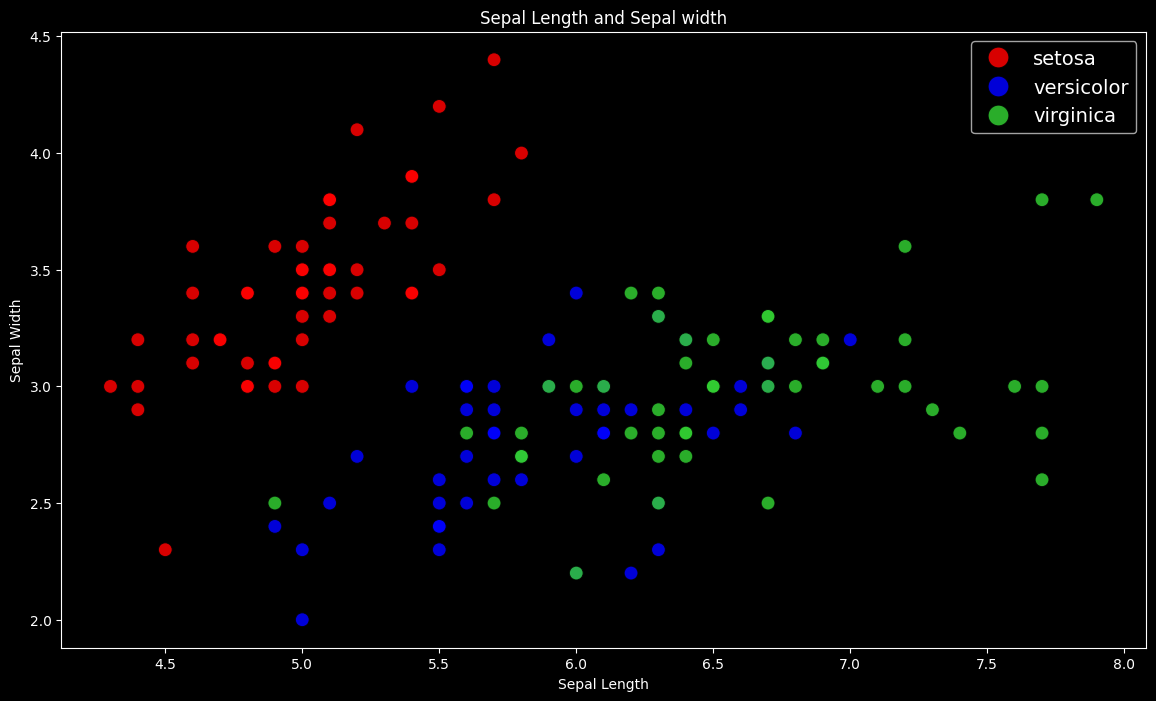

In [15]:
# Call functions with many parameters using one line for each parameter: Readability, flexibility, faster, cleaner code.
sns.scatterplot(data=df,
                x='sepal_length',
                y='sepal_width',
                hue='species',
                palette=['Red', 'Blue', 'Limegreen'],
                # palette = 'Set2', # Try this one.
                edgecolor='black',
                s=100,
                alpha=0.85  # try setting 0.5
)

plt.title('Sepal Length and Sepal width')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend(markerscale=1.5, loc="upper right", prop={'size': 14});  # Try different marker scales.

# plt.savefig("sepal.png")  # Can you guess what does this line of code do?

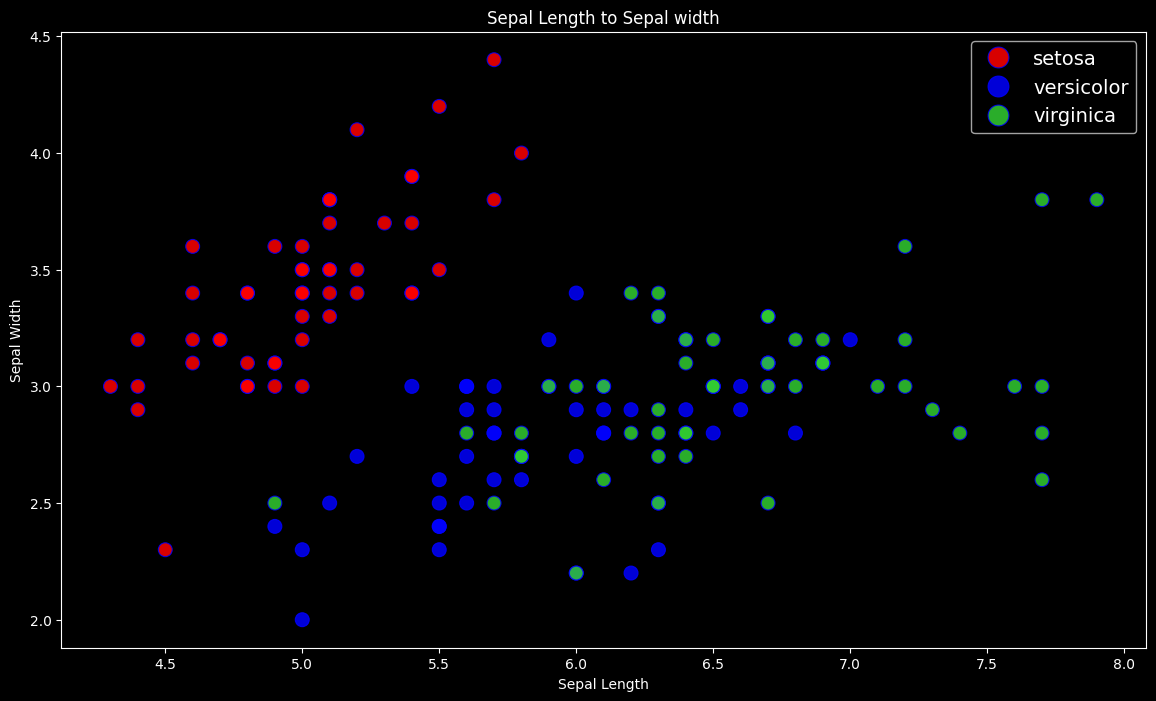

In [16]:
# Spot the three differences in the code between this plot and the one above:
# a)
# b)
# c)

# Call functions with many parameters using one line for each parameter: Readability, flexibility, faster, cleaner code.
sns.scatterplot(
    x='sepal_length',
    y='sepal_width',
    data=df,  # a)
    hue='species',
    palette=['red', 'blue', 'limegreen'],  # b)
    edgecolor='b', # c) Can you guess if this is "black" or "blue"? Explicit is better than implicit.
    s=100,
    alpha=0.85
)

plt.title('Sepal Length to Sepal width')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend(markerscale=1.5, loc="upper right", prop={'size': 14});

# plt.savefig('sepal.png')  # Can you guess what does this line of code do?

#### A3. Petal scatter visualization

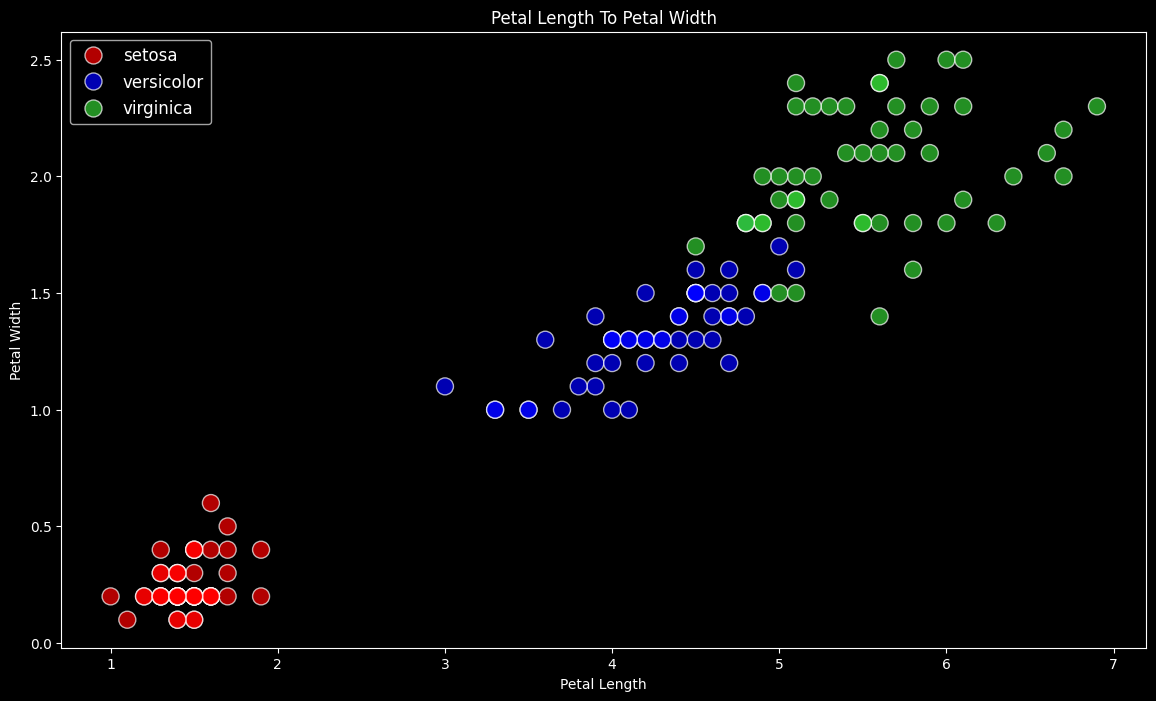

In [17]:
sns.scatterplot(
    x='petal_length', y='petal_width', data=df, hue='species',
    palette = ['Red', 'Blue', 'limegreen'],
    edgecolor = 'w', s = 150, alpha = 0.7
)

plt.title('Petal Length To Petal Width')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.legend(loc = 'upper left', fontsize = 12);

# plt.savefig('petal.png')

In [18]:
# sns.heatmap?

#### A4. Data Heatmap

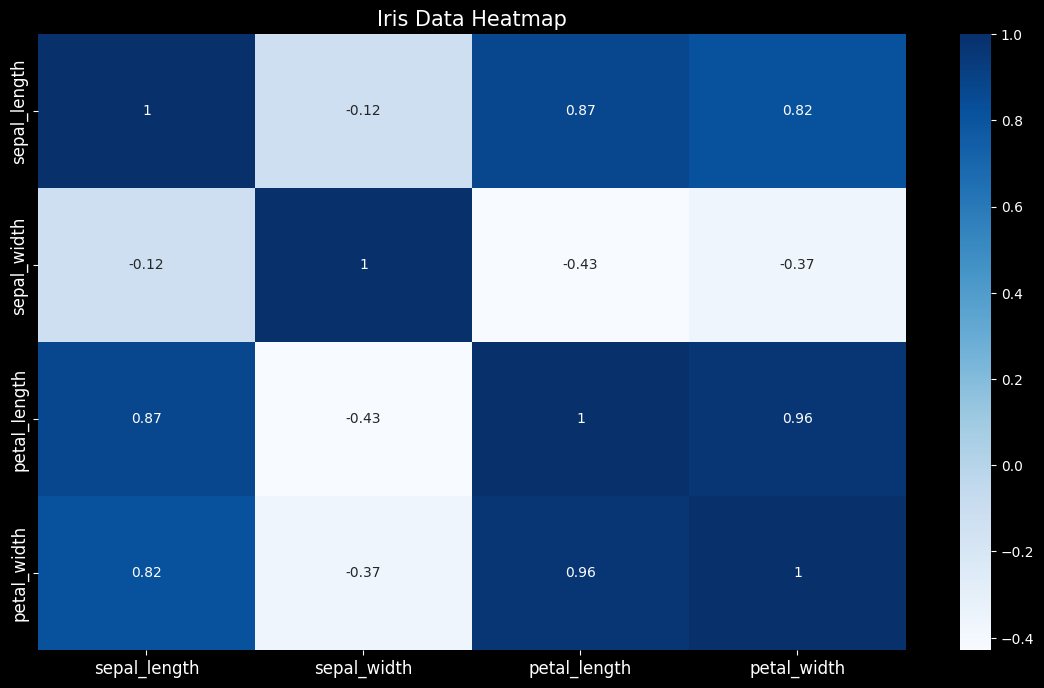

In [19]:
# df_corr = df.corr()  # This used to work until Pandas 2.0. Not anymore.

df_corr = df.corr(numeric_only=True)

sns.heatmap(
    df_corr, annot = True, 
    cmap = 'Blues',
    xticklabels = df_corr.columns.values,
    yticklabels = df_corr.columns.values
);

plt.title('Iris Data Heatmap', fontsize = 15);
plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);

# plt.savefig('heatmap.png')

#### A5. Scatter Matrix

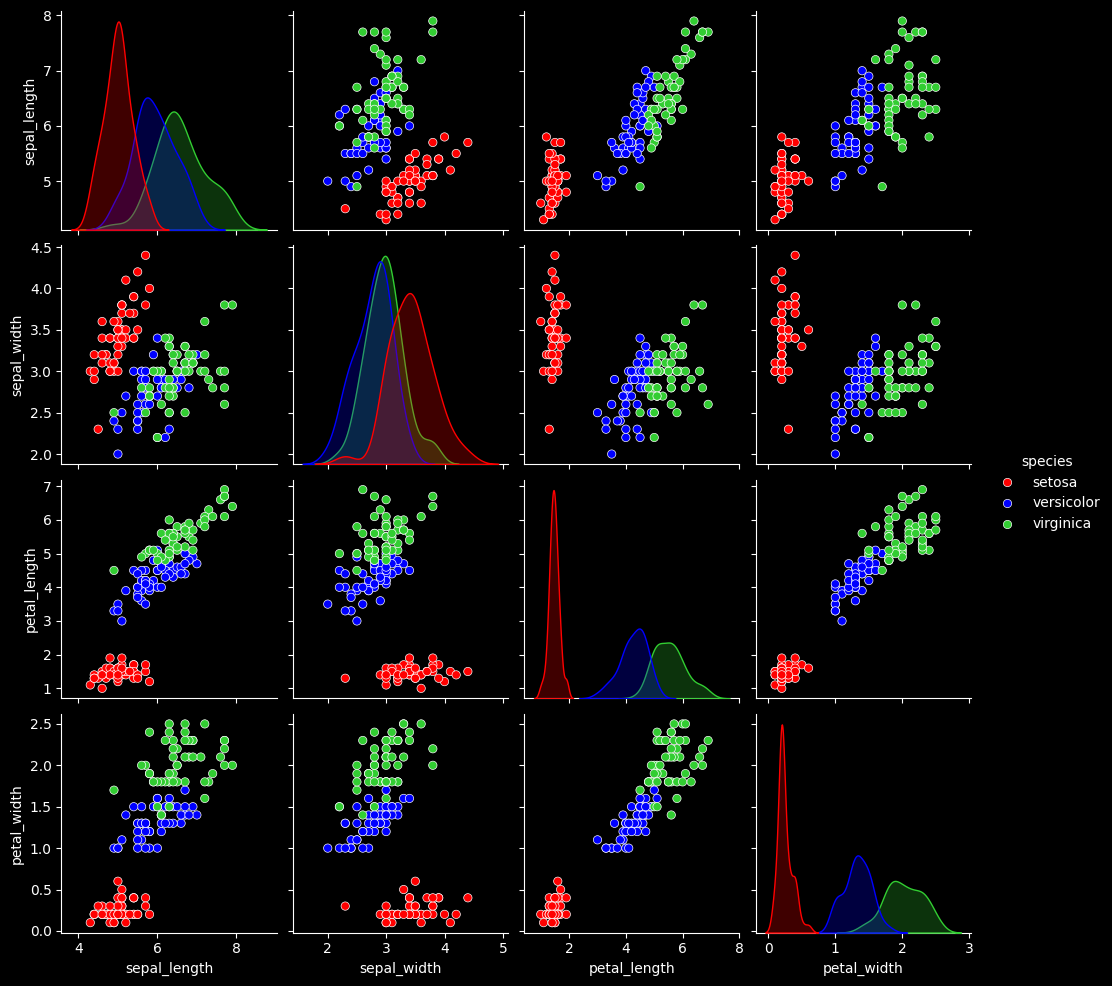

In [20]:
# all features ar numeric, so we use the data as is.
# use the species to 
sns.pairplot(data=df, hue='species', palette=['Red', 'Blue', 'limegreen']);

# plt.savefig('iris_pairplot.png')

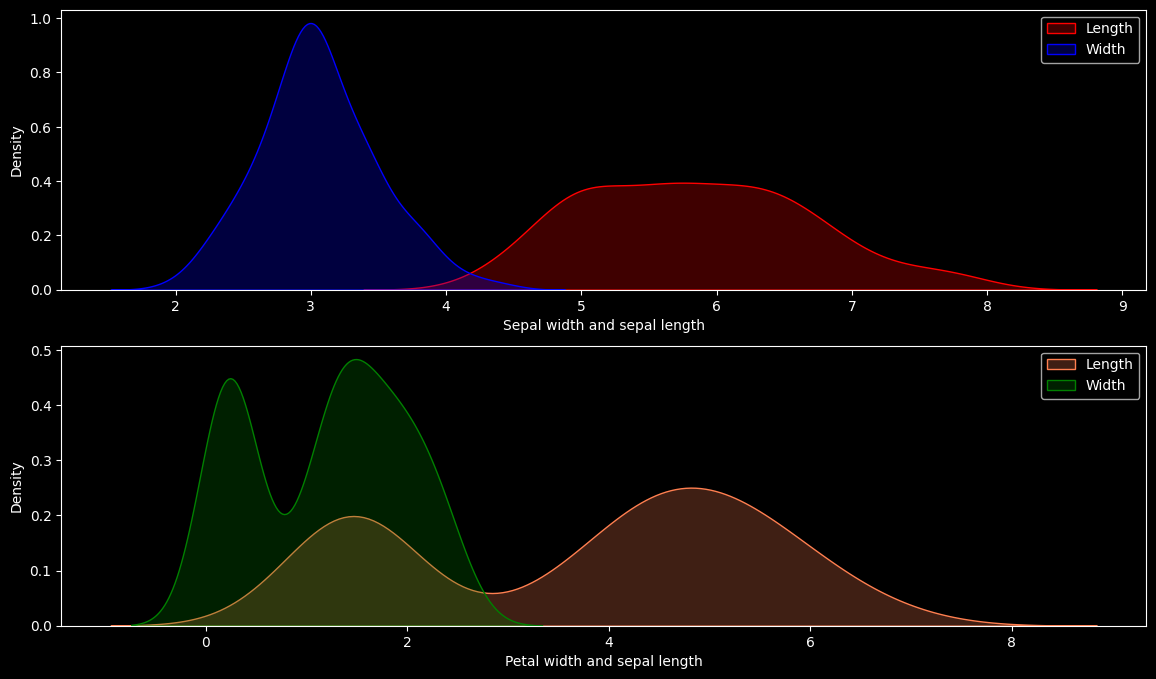

In [21]:
# 5. Distribution plot for all species of iris

ax1 = plt.subplot(211)
# sns.kdeplot(df['sepal_length'], color = 'r', shade = True)  # deprecation warning
# sns.kdeplot(df['sepal_width'], color = 'b', shade = True)
sns.kdeplot(df['sepal_length'], color = 'r', fill = True);
sns.kdeplot(df['sepal_width'], color = 'b', fill = True);
plt.xlabel('Sepal width and sepal length');
plt.legend(["Length", "Width"])


ax2 = plt.subplot(212)
# sns.kdeplot(df['petal_length'], color = 'coral', shade = True);  # deprecation warning
# sns.kdeplot(df['petal_width'], color = 'green', shade = True);
sns.kdeplot(df['petal_length'], color = 'coral', fill = True);
sns.kdeplot(df['petal_width'], color = 'green', fill = True);
plt.xlabel('Petal width and sepal length');
plt.legend(["Length", "Width"])

# plt.savefig('dist.png')

## B. Apply knn, using scikit learn

When using a function from library, a very important thing to know: the "input" data type. Also remember: libraries evolve fast.

### B1. Data Pre-processing 

#### B1.1 Separate:  
* "feature matrix" = (explanatory variables)
* "classification vector" = (target variable)

In [22]:
df.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


In [23]:
# X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].to_numpy()
# convert to numpy array is not necessary, scikit works with pandas dataframes since ages. But that was not always the case.

X = df.iloc[:, :-1]#.to_numpy()
#X = df[["sepal_length",	"sepal_width", 	"petal_length", "petal_width"]]   # Same result as above, but what would you do if you had thousands of features?

y = df['species']#.to_numpy()

In [24]:
X.head(3)
# X[:5]  # same result, pythonic syntax

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [25]:
# 5 Random target variable values
y.sample(5)
# y[:5]

75     versicolor
141     virginica
99     versicolor
112     virginica
48         setosa
Name: species, dtype: object

#### B1.2 Scale the data (if necessary)  

In this case, the features all have the same scale, all are measeured in centimeters and their range is very small.  
So this step is NOT necessary for this dataset.    
Below are some examples of scaling methods, for you to practice.  
Try to see if you get different results.

In [26]:
# standardization = subtract the mean and divide by s. Mean becomes zero and s = 1
# X = StandardScaler().fit_transform(X.astype(float))

# X = MaxAbsScaler().fit_transform(X.astype(float))  # feature_range=[-1, 1]

# X = MinMaxScaler().fit_transform(X.astype(float))  # feature_range=(min, max)

# X.head()

In [27]:
# Range of features values.
(X.max() - X.min())

sepal_length    3.6
sepal_width     2.4
petal_length    5.9
petal_width     2.4
dtype: float64

#### B1.3 Split data in train set and test set   

#### IMPORTANT: k-NN does NOT need TRAIN & TEST => "lazy learning algo".

### B2. Implement the scikit library

#### B2.1 Select N of neighbours and classifier model

In [28]:
# get help in jupyter about the function and its parameters
KNeighborsClassifier?

Init signature:
KNeighborsClassifier(
    n_neighbors=5,
    *,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=None,
)
Docstring:     
Classifier implementing the k-nearest neighbors vote.

Read more in the :ref:`User Guide <classification>`.

Parameters
----------
n_neighbors : int, default=5
    Number of neighbors to use by default for :meth:`kneighbors` queries.

weights : {'uniform', 'distance'}, callable or None, default='uniform'
    Weight function used in prediction.  Possible values:

    - 'uniform' : uniform weights.  All points in each neighborhood
      are weighted equally.
    - 'distance' : weight points by the inverse of their distance.
      in this case, closer neighbors of a query point will have a
      greater influence than neighbors which are further away.
    - [callable] : a user-defined function which accepts an
      array of distances, and returns an array of the same shape

In [29]:
# help(KNeighborsClassifier)  # Extensive documentation.

In [30]:
k = 5  # Number of neighbours

# name that we gave to the "algo" instance
neighbours_clf = KNeighborsClassifier(n_neighbors=k)

In [31]:
neighbours_clf = KNeighborsClassifier()

#### B2.2 Fit the model to the train set (a subset of the data)

In [32]:
neighbours_clf  # Before fitting

KNeighborsClassifier()

In [33]:
neighbours_clf.fit(X, y);

In [34]:
neighbours_clf  # After fitting

KNeighborsClassifier()

#### B2.3 Create predictions on test set

In [35]:
# this creates a new, fifth subset
y_pred = neighbours_clf.predict(X)

In [36]:
y_pred

array(['setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'virginica', 'versicolor', 'virginica', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
     

#### B2.4 predict a single observation

In [37]:
X.head(1)  # first row

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2


In [38]:
X.iloc[0:1]  # first row, same as above different syntax

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2


In [39]:
y_pred_obs_number_one = neighbours_clf.predict(X.iloc[0:1])  # predict class of first row
y_pred_obs_number_one

array(['setosa'], dtype=object)

In [40]:
y[0:1]  # actual class value of first row

0    setosa
Name: species, dtype: object

In [41]:
# Read the warning and undestand it. Data without names, still works because of training.
my_whatever_one_observation_feature_values = [[5.8, 2.8, 5.1, 2.4]]  # array of 4 random values, double brackets.
y_pred_my_whatever_values = neighbours_clf.predict(my_whatever_one_observation_feature_values)

y_pred_my_whatever_values = neighbours_clf.predict([[5.8, 2.8, 5.1, 2.4]])  # same as the line above.
y_pred_my_whatever_values

/home/tharg/venv_projects/uoa_py_course/course_venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/tharg/venv_projects/uoa_py_course/course_venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array(['virginica'], dtype=object)

In [42]:
# Create DataFrame for the new observation to include headers
feature_names = df.columns[:-1]
feature_names

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')

In [43]:
# Create a df (values, columns headers)
one_new_observation_df = pd.DataFrame(my_whatever_one_observation_feature_values, columns=feature_names)

In [44]:
y_pred_my_whatever_values = neighbours_clf.predict(one_new_observation_df)
y_pred_my_whatever_values

array(['virginica'], dtype=object)

In [45]:
# Create predictions
y_pred_first_ten_rows = neighbours_clf.predict(X.iloc[:10])

In [46]:
# Call predictions
y_pred_first_ten_rows

array(['setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa'], dtype=object)

In [47]:
# show classifier classes
neighbours_clf.classes_

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [48]:
# Show probablilities of prediction for class for each observation
neighbours_clf.predict_proba(X)

array([[1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. 

In [49]:
# Old school python:
# Get the predicted probabilities for each sample
probabilities = neighbours_clf.predict_proba(X)

# Find the indices of samples where the maximum probability is not 1
indices = np.where(np.max(probabilities, axis=1) != 1)

# Print these samples and their corresponding probabilities
for i in indices[0]:
    print(f"Sample {i}:")
    print(X.iloc[i])
    print(f"Predicted probabilities: {probabilities[i]}")
    print("\n")

Sample 56:
sepal_length    6.3
sepal_width     3.3
petal_length    4.7
petal_width     1.6
Name: 56, dtype: float64
Predicted probabilities: [0.  0.8 0.2]


Sample 68:
sepal_length    6.2
sepal_width     2.2
petal_length    4.5
petal_width     1.5
Name: 68, dtype: float64
Predicted probabilities: [0.  0.8 0.2]


Sample 70:
sepal_length    5.9
sepal_width     3.2
petal_length    4.8
petal_width     1.8
Name: 70, dtype: float64
Predicted probabilities: [0.  0.4 0.6]


Sample 72:
sepal_length    6.3
sepal_width     2.5
petal_length    4.9
petal_width     1.5
Name: 72, dtype: float64
Predicted probabilities: [0.  0.4 0.6]


Sample 77:
sepal_length    6.7
sepal_width     3.0
petal_length    5.0
petal_width     1.7
Name: 77, dtype: float64
Predicted probabilities: [0.  0.6 0.4]


Sample 83:
sepal_length    6.0
sepal_width     2.7
petal_length    5.1
petal_width     1.6
Name: 83, dtype: float64
Predicted probabilities: [0.  0.2 0.8]


Sample 106:
sepal_length    4.9
sepal_width     2.5
petal_

In [50]:
# Get the predicted probabilities for each sample
probabilities = neighbours_clf.predict_proba(X)

# Find the indices of samples where the maximum probability is not 1
indices = np.where(np.max(probabilities, axis=1) != 1)

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=["Sample"] + list(X.columns) + ["Predicted Probabilities"])

# Loop over the indices
for i in indices[0]:
    # Append the sample index, features and predicted probabilities to the DataFrame
    results_df.loc[len(results_df)] = [i] + list(X.iloc[i]) + [probabilities[i]]

# Print the results DataFrame
results_df

,Sample,sepal_length,sepal_width,petal_length,petal_width,Predicted Probabilities
0,56,6.3,3.3,4.7,1.6,"[0.0, 0.8, 0.2]"
1,68,6.2,2.2,4.5,1.5,"[0.0, 0.8, 0.2]"
2,70,5.9,3.2,4.8,1.8,"[0.0, 0.4, 0.6]"
3,72,6.3,2.5,4.9,1.5,"[0.0, 0.4, 0.6]"
4,77,6.7,3.0,5.0,1.7,"[0.0, 0.6, 0.4]"
5,83,6.0,2.7,5.1,1.6,"[0.0, 0.2, 0.8]"
6,106,4.9,2.5,4.5,1.7,"[0.0, 0.8, 0.2]"
7,110,6.5,3.2,5.1,2.0,"[0.0, 0.2, 0.8]"
8,119,6.0,2.2,5.0,1.5,"[0.0, 0.6, 0.4]"
9,123,6.3,2.7,4.9,1.8,"[0.0, 0.2, 0.8]"


### B3. Evaluate model performance

#### B3.1 Accuracy score

In [51]:
# using the default score()  function of the classifier
neighbours_clf.score(X, y)

0.9666666666666667

In [52]:
# using the scikit learn metric function. Same result
round(accuracy_score(y, y_pred) * 100, 4)

96.6667

In [53]:
y[:10], y_pred[:10]

(0    setosa
 1    setosa
 2    setosa
 3    setosa
 4    setosa
 5    setosa
 6    setosa
 7    setosa
 8    setosa
 9    setosa
 Name: species, dtype: object,
 array(['setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
        'setosa', 'setosa', 'setosa', 'setosa'], dtype=object))

In [54]:
# Create df (column_headers: values)
y_df = pd.DataFrame({'y': y, 'y_pred': y_pred},
                    columns=['y', 'y_pred'])

In [55]:
# Call dateframe
y_df

,y,y_pred
0,setosa,setosa
1,setosa,setosa
2,setosa,setosa
3,setosa,setosa
4,setosa,setosa
...,...,...
145,virginica,virginica
146,virginica,virginica
147,virginica,virginica
148,virginica,virginica


In [56]:
# Create new column with ["column name"] and values = the result of boolean equality y is equal to predicted y

y_df["prediction_outcome"] = (y_df.y == y_df.y_pred)

In [57]:
y_df.head()

,y,y_pred,prediction_outcome
0,setosa,setosa,True
1,setosa,setosa,True
2,setosa,setosa,True
3,setosa,setosa,True
4,setosa,setosa,True


In [58]:
# Filter y_df, get rows of column prediction_outcome is False.
y_df[y_df.prediction_outcome == False]

,y,y_pred,prediction_outcome
70,versicolor,virginica,False
72,versicolor,virginica,False
83,versicolor,virginica,False
106,virginica,versicolor,False
119,virginica,versicolor,False


#### B3.2 Confusion Matrix

In [59]:
# Confusion matrix, manual implementation using pandas crosstab function
pd.crosstab(y, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,setosa,versicolor,virginica,All
True,,,,
setosa,50,0,0,50
versicolor,0,47,3,50
virginica,0,2,48,50
All,50,49,51,150


In [60]:
confusion_matrix?

Signature:
confusion_matrix(
    y_true,
    y_pred,
    *,
    labels=None,
    sample_weight=None,
    normalize=None,
)
Docstring:
Compute confusion matrix to evaluate the accuracy of a classification.

By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` and
predicted to be in group :math:`j`.

Thus in binary classification, the count of true negatives is
:math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
:math:`C_{1,1}` and false positives is :math:`C_{0,1}`.

Read more in the :ref:`User Guide <confusion_matrix>`.

Parameters
----------
y_true : array-like of shape (n_samples,)
    Ground truth (correct) target values.

y_pred : array-like of shape (n_samples,)
    Estimated targets as returned by a classifier.

labels : array-like of shape (n_classes), default=None
    List of labels to index the matrix. This may be used to reorder
    or select a subset of labels.
    If

In [61]:
# Confusion matrix, using ready scikit learn function
confusion_matrix(y, y_pred, labels=["setosa", "versicolor",	"virginica"])

array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0,  2, 48]])

In [62]:
# Confusion matrix,normalize in perventages
confusion_matrix(y, y_pred, normalize="true")

array([[1.  , 0.  , 0.  ],
       [0.  , 0.94, 0.06],
       [0.  , 0.04, 0.96]])

In [63]:
confusion_matrix(y, y_pred, labels=neighbours_clf.classes_)

array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0,  2, 48]])

In [ ]:
cm = confusion_matrix(y, y_pred, labels=neighbours_clf.classes_)

# Get available colormap options for matplotlib
# plt.colormaps()

ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=neighbours_clf.classes_
).plot(
    # cmap="inferno_r"
    cmap='rocket_r'
);

### B4. Compare different number of k for neighbors  
[simple loops](https://www.kaggle.com/jmataya/k-nearest-neighbors-classifier)

In [67]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 20)
accuracy = np.empty(len(neighbors))

In [68]:
# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn_clf = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn_clf.fit(X, y)
    
    #Compute accuracy on the training set
    accuracy[i] = knn_clf.score(X, y)

In [69]:
accuracy

array([1.        , 0.98      , 0.96      , 0.96      , 0.96666667,
       0.97333333, 0.97333333, 0.98      , 0.98      , 0.98      ,
       0.97333333, 0.98      , 0.98      , 0.98      , 0.98666667,
       0.98666667, 0.98      , 0.97333333, 0.98      ])

In [70]:
accuracy[4]  # k =5, index starts from zero

0.9666666666666667

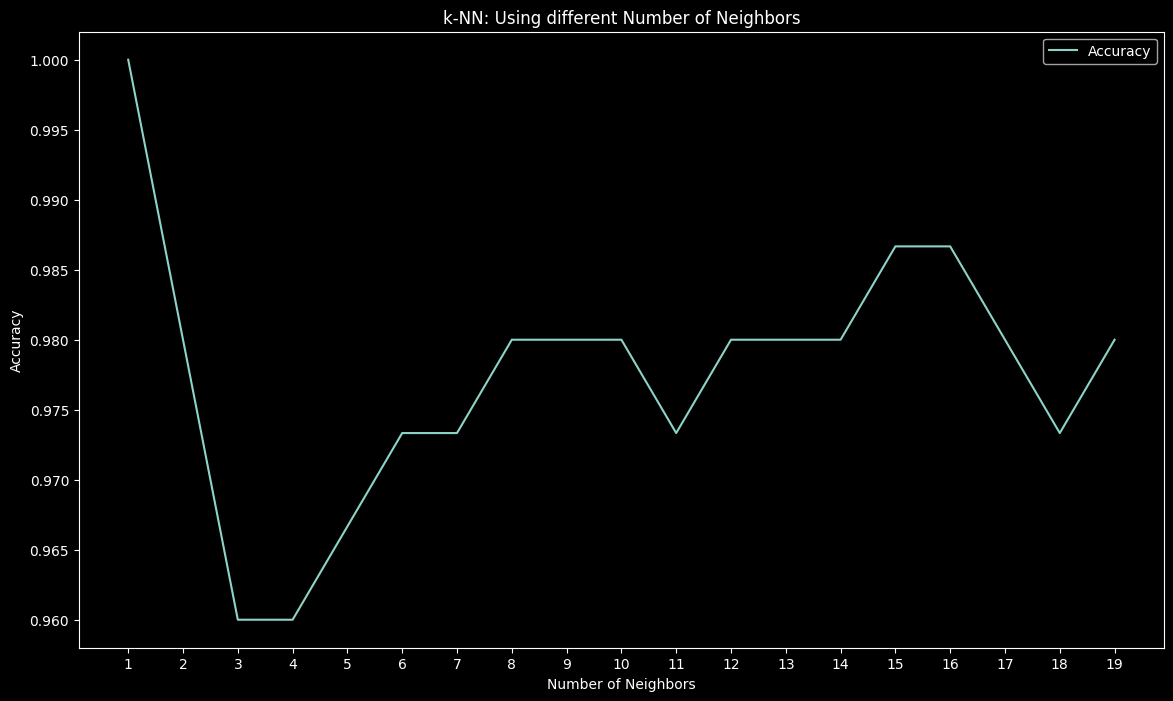

In [71]:
# Generate plot
plt.title('k-NN: Using different Number of Neighbors')
plt.plot(neighbors, accuracy, label='Accuracy')
# plt.plot(neighbors, train_accuracy, label='Training Accuracy')
plt.xticks(range(1, 20))
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')

plt.show()

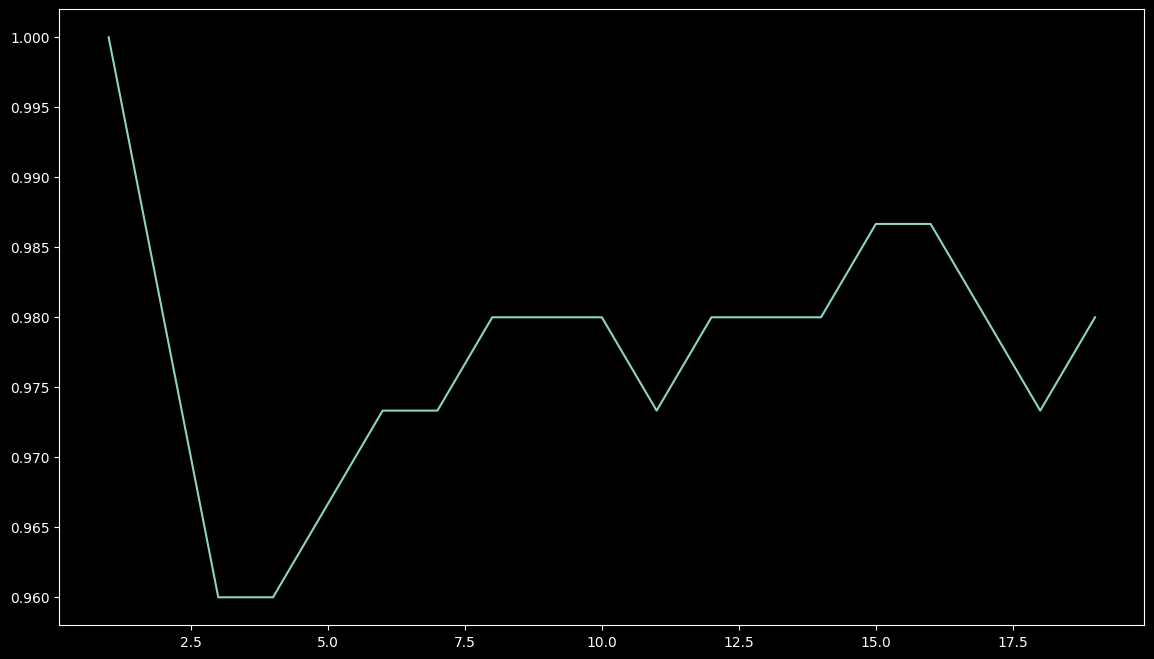

In [72]:
# Generate the same plot as above without setting any parameter values for labels or ticks
plt.plot(neighbors, accuracy, label='Accuracy')
plt.show()

In [73]:
type(accuracy)

numpy.ndarray

In [74]:
max(accuracy)

1.0

In [75]:
# accuracy for 5 neighbours
accuracy[4]

0.9666666666666667

In [76]:
# Apply knn with k=15
fit_neighbours_15 = KNeighborsClassifier(n_neighbors=15).fit(X, y)

In [77]:
y_pred = fit_neighbours_15.predict(X)

In [78]:
confusion_matrix(y, y_pred)

array([[50,  0,  0],
       [ 0, 49,  1],
       [ 0,  1, 49]])

In [79]:
# Initialize variables to store the best number of neighbors and the highest accuracy
best_n = 0
highest_accuracy = 0

# Loop over different values of k from 4 to 30
for n_neighbors in range(4, 31):
    # Train the KNN model on the entire dataset
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X, y)

    # Make predictions on the entire dataset
    y_pred = knn.predict(X)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y, y_pred)

    # If the current model's accuracy is higher than our highest accuracy so far,
    # update our best number of neighbors and highest accuracy
    if accuracy > highest_accuracy:
        best_n = n_neighbors
        highest_accuracy = accuracy

# Print the best number of neighbors and the highest accuracy
print("Best number of neighbors:", best_n)
print("Highest accuracy:", highest_accuracy)

Best number of neighbors: 15
Highest accuracy: 0.9866666666666667


### Apply Knn with k=15 and use wieghts for distance

In [80]:
fit_neighbours_clf = KNeighborsClassifier(n_neighbors=15, weights='distance').fit(X, y)

In [81]:
y_pred = fit_neighbours_clf.predict(X)

In [82]:
confusion_matrix(y, y_pred)

array([[50,  0,  0],
       [ 0, 50,  0],
       [ 0,  0, 50]])

#### WOW: 100% accuracy!   
Important Note: In most cases, uniform weights are not optimal, just a starting point.

## C. Discuss optimal k in general and in case of a "tie".   


Tie-breaking rules:
even or odd k,  
number of classes,
distribution of classes, SOS
size of dataset,  
random class assignment,  
total distance weights (inverse distance)  
different distance metrics,   
loop over different k,  
k-Fold validation of data.

[Scikit learn Knn iris example](https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py)

# In class Exercise  
Implement KNN on a new dataset.

In [83]:
from sklearn import datasets

In [84]:
digits = datasets.load_digits()

In [85]:
dir(digits)

['DESCR', 'data', 'feature_names', 'frame', 'images', 'target', 'target_names']

In [86]:
type(digits)  # custom Dictionary-like type

sklearn.utils._bunch.Bunch

In [87]:
print(digits.keys())

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [88]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 1797
:Number of Attributes: 64
:Attribute Information: 8x8 image of integer pixels in the range 0..16.
:Missing Attribute Values: None
:Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
:Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an in

In [89]:
digits.target[100]

4

In [90]:
digits.target[1282]

9

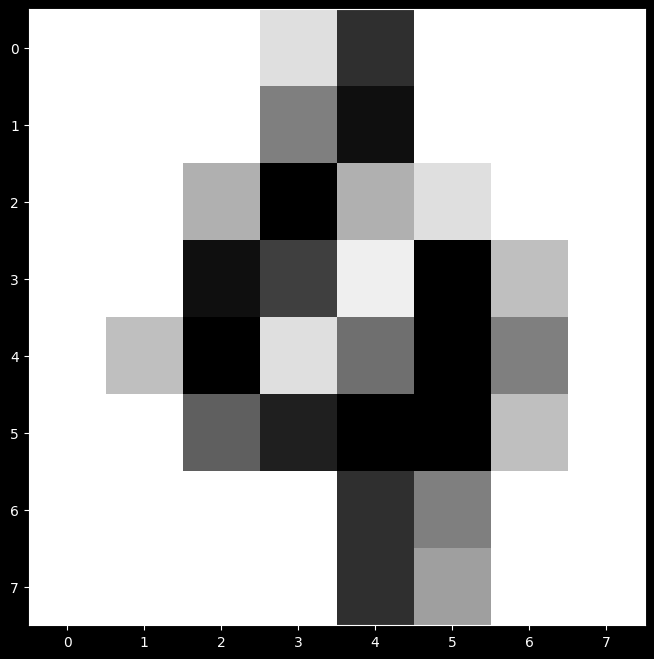

In [91]:
# Display digit observation 1010
plt.imshow(
    digits.images[100],
    cmap=plt.cm.gray_r,
    interpolation='nearest');

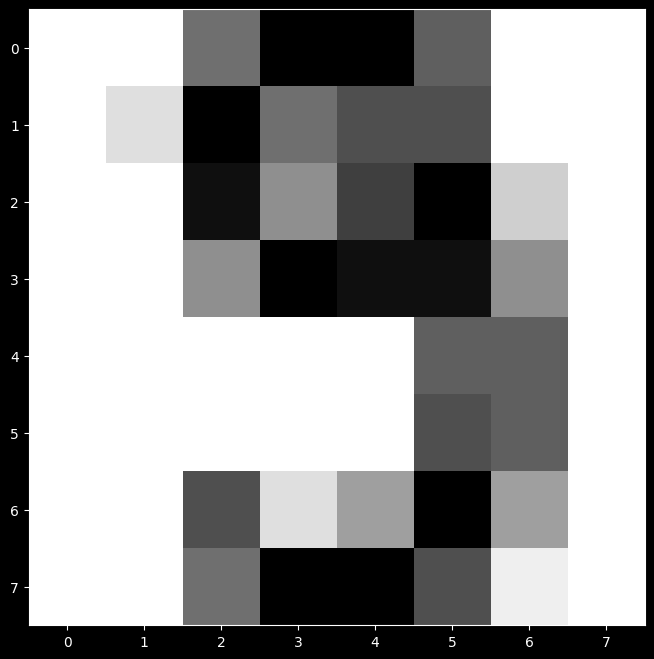

In [92]:
plt.imshow(digits.images[1282], cmap=plt.cm.gray_r, interpolation='nearest');

[Convert scikit learn data to pandas dataframe](https://stackoverflow.com/a/46379878)  (How it was donw some years ago).

In [93]:
digits.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [94]:
digits.target_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [95]:
# digits.feature_names  # Show column names

### The floor is yours!

In [96]:
digits = datasets.load_digits(as_frame=True)

In [97]:
digits.data.head(5)

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [98]:
digits.target.sample(3)

191     7
1403    2
1635    7
Name: target, dtype: int64

In [99]:
digits.data["pixel_4_4"]

0        0.0
1       16.0
2       15.0
3       12.0
4        0.0
        ... 
1792     4.0
1793     0.0
1794    16.0
1795    14.0
1796    15.0
Name: pixel_4_4, Length: 1797, dtype: float64

#### Fastest and optimal way to solve this:
Open the notebook in Pycharm and open copilot chat. Type in prompt:   
"Solve the inclass Exercise without splitting to train and test and without scaling the data. Show max accuracy".

In [100]:
## This is what copilot returned.
# Split the dataset into features (X) and target (y)
digits = datasets.load_digits(as_frame=True)
X = digits.data
y = digits.target

# Initialize variables to store the best number of neighbors and the highest accuracy
best_n = 0
highest_accuracy = 0

# Loop over different values of k from 4 to 30
for n_neighbors in range(4, 31):
    # Train the KNN model on the entire dataset
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X, y)

    # Make predictions on the entire dataset
    y_pred = knn.predict(X)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y, y_pred)

    # If the current model's accuracy is higher than our highest accuracy so far,
    # update our best number of neighbors and highest accuracy
    if accuracy > highest_accuracy:
        best_n = n_neighbors
        highest_accuracy = accuracy

# Print the best number of neighbors and the highest accuracy
print("Best number of neighbors:", best_n)
print("Highest accuracy:", highest_accuracy)

Best number of neighbors: 4
Highest accuracy: 0.9922092376182526
